In [1]:
!pip install tensorflow
!pip install matplotlib
!pip install scikit-learn
!pip install scipy
!pip install efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydrive2 1.21.3 r

IMPORTS

In [2]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


2025-11-29 08:15:47.349888: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764404147.547197      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764404147.619432      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


configuration

In [3]:
# --- 1. CONFIGURATION ---
DATASET_DIR = '/kaggle/input/cervical-cancer-largest-dataset-sipakmed'
WORKING_DIR = '/kaggle/working'
TRAIN_DIR = os.path.join(WORKING_DIR, 'train')
VAL_DIR = os.path.join(WORKING_DIR, 'val')
TEST_DIR = os.path.join(WORKING_DIR, 'test')

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30  # We set high, EarlyStopping will cut it short if needed
LEARNING_RATE = 0.001

# Clean working directory to prevent errors on re-run
for dir_path in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.makedirs(dir_path)


DATA PREPARATION

In [4]:
# --- 2. DATA PREPARATION (Handle SIPaKMeD Structure) ---
print("--- Organizing Dataset ---")

# Find class names
class_names = [d for d in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, d))]
class_names.sort()

for class_name in class_names:
    # Logic to find images in nested folders (Class -> Class -> Images)
    class_path = os.path.join(DATASET_DIR, class_name, class_name)
    if not os.path.exists(class_path):
        class_path = os.path.join(DATASET_DIR, class_name)
    
    if not os.path.exists(class_path): continue

    # Get all BMP/JPG images
    images = [os.path.join(class_path, f) for f in os.listdir(class_path) 
              if f.lower().endswith(('.bmp', '.jpg', '.png'))]
    
    if len(images) == 0: continue

    # Split: 70% Train, 15% Val, 15% Test
    train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42, shuffle=True)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42, shuffle=True)

    # Helper function to copy
    def copy_images(file_list, destination):
        dest_class_dir = os.path.join(destination, class_name)
        os.makedirs(dest_class_dir, exist_ok=True)
        for img in file_list:
            shutil.copy(img, os.path.join(dest_class_dir, os.path.basename(img)))

    copy_images(train_imgs, TRAIN_DIR)
    copy_images(val_imgs, VAL_DIR)
    copy_images(test_imgs, TEST_DIR)

print(f"Data organized successfully. Classes: {class_names}")

--- Organizing Dataset ---
Data organized successfully. Classes: ['im_Dyskeratotic', 'im_Koilocytotic', 'im_Metaplastic', 'im_Parabasal', 'im_Superficial-Intermediate']


DATA AUGMENTATION

In [5]:
# --- 3. DATA AUGMENTATION & GENERATORS ---

# Custom CNNs usually prefer 1./255 scaling (Normalizing to 0-1 range)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Important for Classification Report
)

NUM_CLASSES = len(class_names)

Found 674 images belonging to 5 classes.
Found 145 images belonging to 5 classes.
Found 147 images belonging to 5 classes.


**BUILD CUSTOM CNN MODEL******

In [6]:
# --- 4. BUILD CUSTOM CNN MODEL ---

def build_custom_cnn():
    model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Block 2
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Block 3
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Block 4
        Conv2D(256, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        
        # Fully Connected Head
        Flatten(),
        Dense(512),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5), # Regularization
        
        # Output Layer
        Dense(NUM_CLASSES, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_custom_cnn()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1764404275.007512      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764404275.008195      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 26,085,573 (99.51 MB)

 Trainable params: 26,083,589 (99.50 MB)

 Non-trainable params: 1,984 (7.75 KB)

**TRAINING******

In [7]:
# --- 5. TRAINING ---

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=7,          # Wait 7 epochs before stopping if no improvement
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3, 
    min_lr=1e-6,
    verbose=1
)

print("\n--- Starting Training ---")
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr]
)


--- Starting Training ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1764404281.529526     109 service.cc:148] XLA service 0x78183c00a1b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764404281.530424     109 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764404281.530448     109 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764404282.135628     109 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/22 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.1719 - loss: 2.7279 

I0000 00:00:1764404289.398026     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


22/22 ━━━━━━━━━━━━━━━━━━━━ 29s 828ms/step - accuracy: 0.4271 - loss: 1.9495 - val_accuracy: 0.2621 - val_loss: 1.5791 - learning_rate: 0.0010
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 577ms/step - accuracy: 0.6234 - loss: 0.9209 - val_accuracy: 0.1310 - val_loss: 1.8473 - learning_rate: 0.0010
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 548ms/step - accuracy: 0.7109 - loss: 0.8117 - val_accuracy: 0.1103 - val_loss: 2.2927 - learning_rate: 0.0010
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - accuracy: 0.6638 - loss: 0.9351
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 559ms/step - accuracy: 0.6636 - loss: 0.9354 - val_accuracy: 0.1103 - val_loss: 3.6158 - learning_rate: 0.0010
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 567ms/step - accuracy: 0.6804 - loss: 0.8545 - val_accuracy: 0.1103 - val_loss: 4.3469 - learning_rate: 2.0000e-04
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 546ms/step - accuracy: 0.7578 - loss: 0.6160 - v

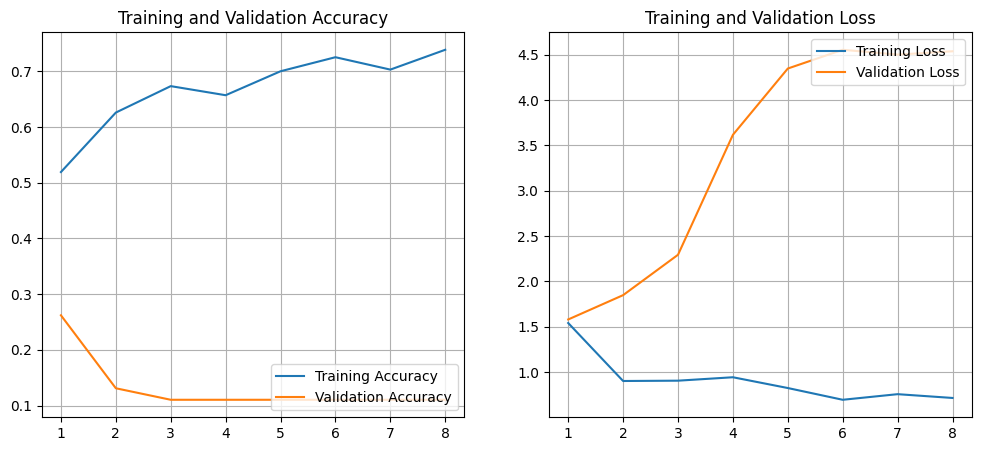


--- Evaluation on Test Set ---
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 479ms/step

Classification Report:
                             precision    recall  f1-score   support

            im_Dyskeratotic       0.00      0.00      0.00        34
            im_Koilocytotic       0.28      0.75      0.41        36
             im_Metaplastic       0.50      0.07      0.13        41
               im_Parabasal       0.20      0.53      0.29        17
im_Superficial-Intermediate       0.00      0.00      0.00        19

                   accuracy                           0.27       147
                  macro avg       0.20      0.27      0.17       147
               weighted avg       0.23      0.27      0.17       147



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


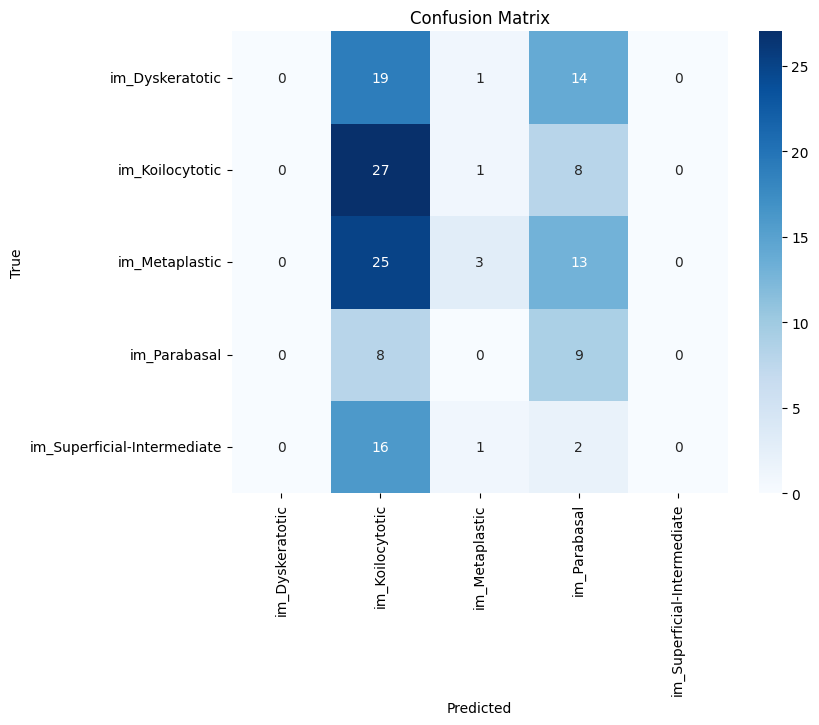

In [8]:
# --- 6. PLOTTING RESULTS ---

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    
    plt.show()

plot_history(history)

# --- 7. EVALUATION ---

print("\n--- Evaluation on Test Set ---")
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# Get Label Names
class_indices = test_generator.class_indices
target_names = list(class_indices.keys())

# Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()